Initial shape: (46011, 9)
Shape after cleaning: (45561, 9)


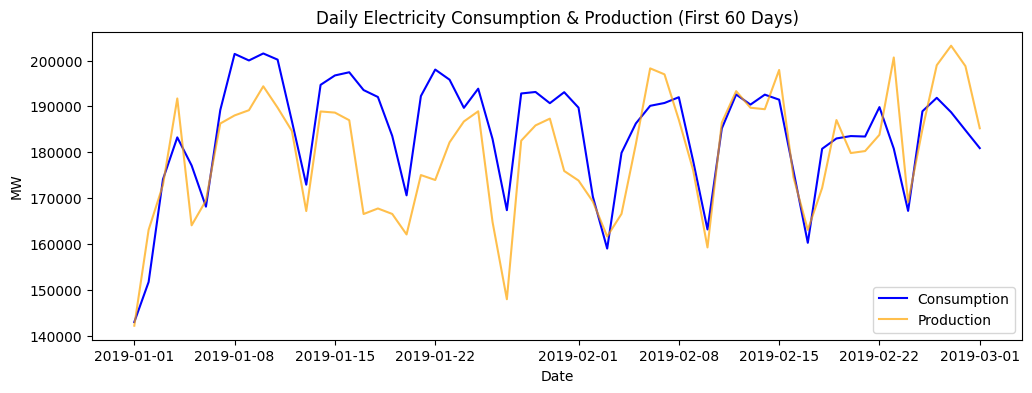

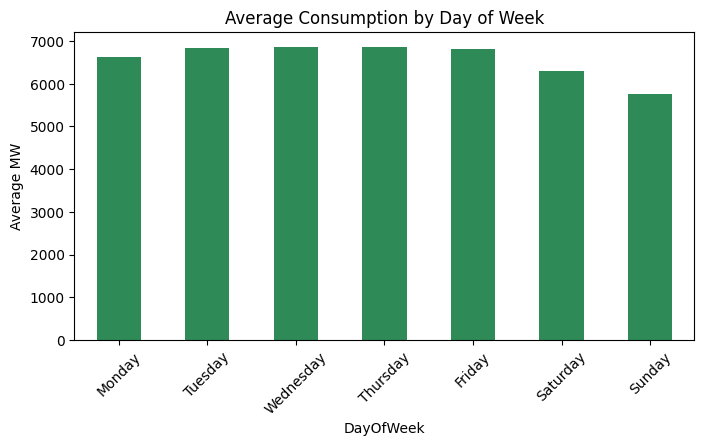

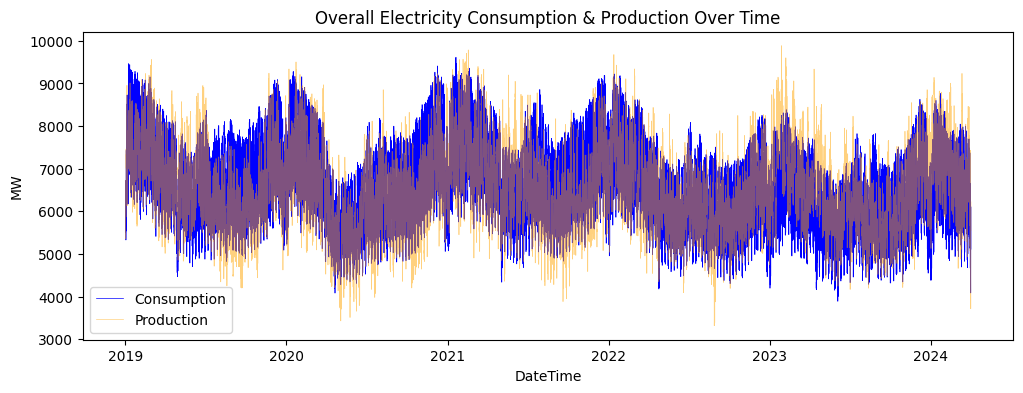

Feature engineering complete. Shape: (45392, 26)
Processed data saved to: ../data/processed/electricity_processed.csv


In [2]:
# ========================================================
# 1️⃣ DATA LOADING, EDA, & FEATURE ENGINEERING
# ========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- PATH CORRECTION ---
# "../" tells the computer to go out of 'notebooks' and look at the main project folder
OUTPUT_FOLDER = "../outputs"
PROCESSED_DATA_FOLDER = "../data/processed"
RAW_DATA_PATH = "../data/raw/electricity.csv"

# Create folders if they don't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(PROCESSED_DATA_FOLDER, exist_ok=True)

# 1. Load Dataset
df = pd.read_csv(RAW_DATA_PATH)

# Convert DateTime and set as index
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# 2. Missing Values & Duplicates
print(f"Initial shape: {df.shape}")
df = df.drop_duplicates()
df = df.ffill() 
print(f"Shape after cleaning: {df.shape}")

# 3. Aggregations for EDA
df_daily = df.resample('D').sum()

df['DayOfWeek'] = df.index.day_name()
avg_by_day = df.groupby('DayOfWeek')['Consumption'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

# --------------------------------------------------------
# 📊 Exploratory Data Analysis (EDA) - PLOTS
# --------------------------------------------------------

# Plot 1: Daily trends (60 days)
plt.figure(figsize=(12,4))
plt.plot(df_daily['Consumption'].iloc[:60], label='Consumption', color='blue')
plt.plot(df_daily['Production'].iloc[:60], label='Production', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('MW')
plt.title('Daily Electricity Consumption & Production (First 60 Days)')
plt.legend()
plt.savefig(f'{OUTPUT_FOLDER}/01_daily_trends_60d.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Day of Week Average
plt.figure(figsize=(8,4))
avg_by_day.plot(kind='bar', color='seagreen')
plt.ylabel('Average MW')
plt.title('Average Consumption by Day of Week')
plt.xticks(rotation=45)
plt.savefig(f'{OUTPUT_FOLDER}/02_avg_consumption_dow.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Overall Time Series
plt.figure(figsize=(12,4))
plt.plot(df['Consumption'], label='Consumption', color='blue', linewidth=0.5)
plt.plot(df['Production'], label='Production', color='orange', alpha=0.5, linewidth=0.5)
plt.xlabel('DateTime')
plt.ylabel('MW')
plt.title('Overall Electricity Consumption & Production Over Time')
plt.legend()
plt.savefig(f'{OUTPUT_FOLDER}/03_overall_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------------
# ⚙️ Feature Engineering
# --------------------------------------------------------

# 1. Lag Features
df['lag_1'] = df['Consumption'].shift(1)
df['lag_24'] = df['Consumption'].shift(24)
df['lag_168'] = df['Consumption'].shift(168)

# 2. Rolling Averages
df['rolling_3h'] = df['Consumption'].shift(1).rolling(window=3).mean()
df['rolling_24h'] = df['Consumption'].shift(1).rolling(window=24).mean()

# 3. Time-Based & Cyclic Features
df['hour'] = df.index.hour
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

# Cyclic Transformations (Sine/Cosine)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 4. Seasonal Features
def assign_season(month):
    if month in [12,1,2]: return 'winter'
    elif month in [3,4,5]: return 'spring'
    elif month in [6,7,8]: return 'summer'
    else: return 'fall'

df['season'] = df['month'].map(assign_season)
df = pd.get_dummies(df, columns=['season'], drop_first=True)

for col in ['season_spring','season_summer','season_winter']:
    if col in df.columns:
        df[col] = df[col].astype(int)

# 5. Target & Cleanup
df['target'] = df['Consumption'].shift(-1)
df_model = df.dropna().copy()
df_model = df_model.select_dtypes(include=[np.number])

# 6. Save Processed Data to correct folder
df_model.to_csv(f'{PROCESSED_DATA_FOLDER}/electricity_processed.csv')
print(f"Feature engineering complete. Shape: {df_model.shape}")
print(f"Processed data saved to: {PROCESSED_DATA_FOLDER}/electricity_processed.csv")


In [23]:
# =========================
# 1️⃣ Linear Regression (Baseline) with Scaling
# =========================

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Define features and target
X = df_model.drop(columns=['target']).copy()
y = df_model['target']

# Convert non-numeric features
for col in X.columns:
    if X[col].dtype == 'bool':       # Booleans -> 0/1
        X[col] = X[col].astype(int)
    elif X[col].dtype == 'object':   # Strings -> categorical codes
        X[col] = X[col].astype('category').cat.codes

# Initialize model
lr_model = LinearRegression()

# Store metrics for each fold
rmse_scores = []
mae_scores = []
r2_scores = []

# Time Series Cross-Validation
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Scale numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    lr_model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = lr_model.predict(X_test_scaled)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    print(f"Fold {fold}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

# Average metrics
print("\n=== Average Metrics Across Folds ===")
print(f"RMSE: {np.mean(rmse_scores):.2f}")
print(f"MAE: {np.mean(mae_scores):.2f}")
print(f"R²: {np.mean(r2_scores):.3f}")


Fold 1: RMSE=167.64, MAE=128.69, R²=0.976
Fold 2: RMSE=161.19, MAE=121.59, R²=0.976
Fold 3: RMSE=159.08, MAE=118.58, R²=0.975
Fold 4: RMSE=201.18, MAE=132.97, R²=0.950
Fold 5: RMSE=148.11, MAE=114.10, R²=0.976

=== Average Metrics Across Folds ===
RMSE: 167.44
MAE: 123.19
R²: 0.971


In [24]:
# =========================
# 2️⃣ k-NN Regression with Scaling and Hyperparameter Search
# =========================

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools

# Define features and target
X = df_model.drop(columns=['target']).copy()
y = df_model['target']

# Convert non-numeric features
for col in X.columns:
    if X[col].dtype == 'bool':  # booleans -> 0/1
        X[col] = X[col].astype(int)
    elif X[col].dtype == 'object':  # strings -> categorical codes
        X[col] = X[col].astype('category').cat.codes

# Hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

best_rmse = np.inf
best_params = {}

# Time Series Cross-Validation with scaling
for n, w, p in itertools.product(param_grid['n_neighbors'], 
                                 param_grid['weights'], 
                                 param_grid['p']):
    
    fold_rmse = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Scale numeric features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit k-NN model
        knn_model = KNeighborsRegressor(n_neighbors=n, weights=w, p=p)
        knn_model.fit(X_train_scaled, y_train)
        y_pred = knn_model.predict(X_test_scaled)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        fold_rmse.append(rmse)
    
    avg_rmse = np.mean(fold_rmse)
    
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = {'n_neighbors': n, 'weights': w, 'p': p}

print("Best k-NN Configuration:")
print(best_params)
print(f"Best Average RMSE: {best_rmse:.2f}")


Best k-NN Configuration:
{'n_neighbors': 9, 'weights': 'distance', 'p': 1}
Best Average RMSE: 258.08


In [25]:
# =========================
# 3️⃣ Random Forest Regressor with Hyperparameter Tuning
# =========================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np

# Define features and target
X = df_model.drop(columns=['target']).copy()
y = df_model['target']

# Convert non-numeric features
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    elif X[col].dtype == 'object':
        X[col] = X[col].astype('category').cat.codes

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2']
}

best_rmse = float('inf')
best_params = {}

# CV and hyperparameter search
for n_est, depth, min_leaf, max_feat in itertools.product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['min_samples_leaf'],
        param_grid['max_features']):
    
    fold_rmse = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        rf_model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_leaf=min_leaf,
            max_features=max_feat,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    avg_rmse = np.mean(fold_rmse)
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = {
            'n_estimators': n_est,
            'max_depth': depth,
            'min_samples_leaf': min_leaf,
            'max_features': max_feat
        }

print("Best Random Forest Configuration:")
print(best_params)
print(f"Best Average RMSE: {best_rmse:.2f}")


Best Random Forest Configuration:
{'n_estimators': 100, 'max_depth': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Average RMSE: 141.92


In [26]:
# =========================
# 4️⃣ Gradient Boosting (HistGradientBoostingRegressor) with Hyperparameter Tuning
# =========================

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np

# Define features and target
X = df_model.drop(columns=['target']).copy()
y = df_model['target']

# Convert non-numeric features
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    elif X[col].dtype == 'object':
        X[col] = X[col].astype('category').cat.codes

# Hyperparameter grid
param_grid = {
    'max_iter': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_samples_leaf': [1, 3, 5]
}

best_rmse = float('inf')
best_params = {}

# CV and hyperparameter search
for max_iter, depth, lr, min_leaf in itertools.product(
        param_grid['max_iter'],
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['min_samples_leaf']):
    
    fold_rmse = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        gb_model = HistGradientBoostingRegressor(
            max_iter=max_iter,
            max_depth=depth,
            learning_rate=lr,
            min_samples_leaf=min_leaf,
            random_state=42
        )
        gb_model.fit(X_train, y_train)
        y_pred = gb_model.predict(X_test)
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    avg_rmse = np.mean(fold_rmse)
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = {
            'max_iter': max_iter,
            'max_depth': depth,
            'learning_rate': lr,
            'min_samples_leaf': min_leaf
        }

print("Best Gradient Boosting Configuration:")
print(best_params)
print(f"Best Average RMSE: {best_rmse:.2f}")


Best Gradient Boosting Configuration:
{'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_samples_leaf': 3}
Best Average RMSE: 108.88


In [27]:
# =========================
# 5️⃣ XGBoost Regressor with Hyperparameter Tuning
# =========================

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np

# Features and target
X = df_model.drop(columns=['target']).copy()
y = df_model['target']

# Convert non-numeric
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    elif X[col].dtype == 'object':
        X[col] = X[col].astype('category').cat.codes

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 5]
}

best_rmse = float('inf')
best_params = {}

# CV and hyperparameter search
for n_est, depth, lr, min_child in itertools.product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['min_child_weight']):
    
    fold_rmse = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        xgb_model = XGBRegressor(
            n_estimators=n_est,
            max_depth=depth,
            learning_rate=lr,
            min_child_weight=min_child,
            random_state=42,
            n_jobs=-1
        )
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    avg_rmse = np.mean(fold_rmse)
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = {
            'n_estimators': n_est,
            'max_depth': depth,
            'learning_rate': lr,
            'min_child_weight': min_child
        }

print("Best XGBoost Configuration:")
print(best_params)
print(f"Best Average RMSE: {best_rmse:.2f}")


Best XGBoost Configuration:
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_weight': 5}
Best Average RMSE: 108.09


In [28]:
# =========================
# 6️⃣ LightGBM Regressor with Hyperparameter Tuning
# =========================

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np

# Features and target
X = df_model.drop(columns=['target']).copy()
y = df_model['target']

# Convert non-numeric
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    elif X[col].dtype == 'object':
        X[col] = X[col].astype('category').cat.codes

# Hyperparameter grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

best_rmse = float('inf')
best_params = {}

# CV and hyperparameter search
for num_leaves, depth, lr, n_est in itertools.product(
        param_grid['num_leaves'],
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['n_estimators']):
    
    fold_rmse = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_model = lgb.LGBMRegressor(
            num_leaves=num_leaves,
            max_depth=depth,
            learning_rate=lr,
            n_estimators=n_est,
            random_state=42,
            n_jobs=-1
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_test)
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    avg_rmse = np.mean(fold_rmse)
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = {
            'num_leaves': num_leaves,
            'max_depth': depth,
            'learning_rate': lr,
            'n_estimators': n_est
        }

print("Best LightGBM Configuration:")
print(best_params)
print(f"Best Average RMSE: {best_rmse:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3407
[LightGBM] [Info] Number of data points in the train set: 7567, number of used features: 25
[LightGBM] [Info] Start training from score 6805.170741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [3]:
# =========================
# 🔹 SARIMA (Laptop-Safe Hourly)
# =========================
import pmdarima as pm
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Slice for speed
sarima_slice = df['Consumption'].tail(1000).ffill()
train_s = sarima_slice.iloc[:-24]
test_s = sarima_slice.iloc[-24:]

print("SARIMA Training: Started...")
start_time = time.time()

# Fit model
safe_sarima = pm.auto_arima(
    train_s,
    seasonal=True, m=24,
    stepwise=True,
    approximation=True,
    max_p=2, max_q=2,
    suppress_warnings=True,
    error_action='ignore'
)

end_time = time.time()
print(f"SARIMA Training: Completed in {end_time - start_time:.2f} seconds.")

# Results
sarima_pred = safe_sarima.predict(n_periods=24)
sarima_rmse = np.sqrt(mean_squared_error(test_s, sarima_pred))
sarima_mae = mean_absolute_error(test_s, sarima_pred)
sarima_r2 = r2_score(test_s, sarima_pred)

print(f"\nSARIMA Results for the next 24 hours:")
print(f"RMSE: {sarima_rmse:.4f}")
print(f"MAE:  {sarima_mae:.4f}")
print(f"R²:   {sarima_r2:.4f}")

SARIMA Training: Started...
SARIMA Training: Completed in 177.23 seconds.

SARIMA Results for the next 24 hours:
RMSE: 318.4037
MAE:  261.3425
R²:   0.6196


In [4]:
# =========================
# 🔹 FINAL MODEL EVALUATION (ML + SARIMA + PERSISTENCE)
# =========================
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# 1. Setup Data
X = df_model.drop(columns=['target']).copy()
y = df_model['target']

# 2. Define ML Models
models = {
    'LinearRegression': LinearRegression(),
    'k-NN': KNeighborsRegressor(n_neighbors=5, weights='distance'),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, n_jobs=-1, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=-1)
}

# 3. Evaluation Loop (Time Series Cross-Validation)
tscv = TimeSeriesSplit(n_splits=5)
results_list = []
last_fold_predictions = {}

for model_name, model in models.items():
    rmse_scores, mae_scores, r2_scores = [], [], []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if model_name in ['LinearRegression', 'k-NN']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled, X_test_scaled = X_train, X_test

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    results_list.append({
        'Model': model_name,
        'RMSE': np.mean(rmse_scores),
        'MAE': np.mean(mae_scores),
        'R2': np.mean(r2_scores)
    })
    last_fold_predictions[model_name] = (y_test, y_pred)

# 4. Persistence Baseline (Lag 24)
y_test_final = y.iloc[test_idx]
y_persistence = X.iloc[test_idx]['lag_24']
last_fold_predictions['Persistence (Lag 24)'] = (y_test_final, y_persistence)

results_list.append({
    'Model': 'Persistence (Lag 24)',
    'RMSE': np.sqrt(mean_squared_error(y_test_final, y_persistence)),
    'MAE': mean_absolute_error(y_test_final, y_persistence),
    'R2': r2_score(y_test_final, y_persistence)
})

# 5. Combine & Save
summary = pd.DataFrame(results_list)
try:
    sarima_row = pd.DataFrame([{'Model': 'SARIMA', 'RMSE': sarima_rmse, 'MAE': sarima_mae, 'R2': sarima_r2}])
    summary = pd.concat([summary, sarima_row], ignore_index=True)
except NameError:
    pass

summary = summary.sort_values('RMSE').reset_index(drop=True).round(4)
summary.to_csv('../outputs/04_model_performance_summary.csv', index=False)
display(summary)

,Model,RMSE,MAE,R2
0,LightGBM,108.7317,79.1750,0.9878
1,XGBoost,110.4876,80.9003,0.9874
2,RandomForest,123.2396,90.8516,0.9844
3,LinearRegression,167.4404,123.1857,0.9706
4,SARIMA,318.4037,261.3425,0.6196
5,k-NN,323.8413,250.1863,0.8890
6,Persistence (Lag 24),647.1135,486.9118,0.5403


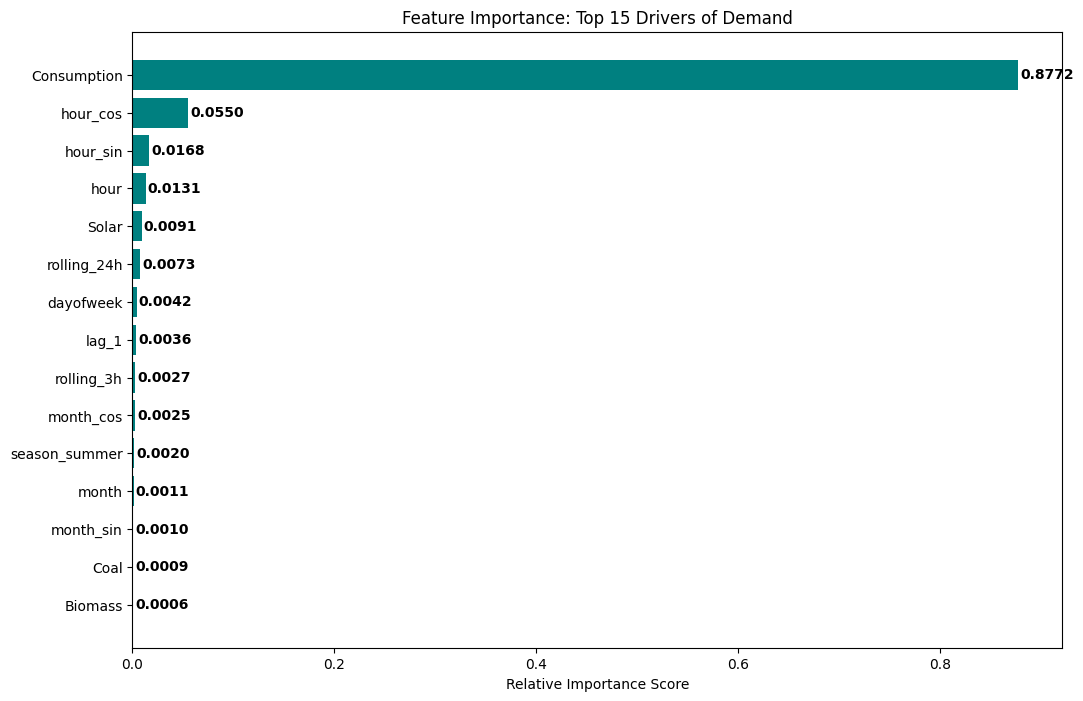

In [5]:
# =========================
# 🔹 FEATURE IMPORTANCE (With Data Labels & Saving)
# =========================

# We use XGBoost as it usually performs well on this type of data
best_xgb = models['XGBoost']
best_xgb.fit(X, y)

importances = best_xgb.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-15:] 

plt.figure(figsize=(12, 8))
plt.title('Feature Importance: Top 15 Drivers of Demand')
bars = plt.barh(range(len(indices)), importances[indices], align='center', color='teal')

# Add values to bars so they are readable even if small
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', fontweight='bold')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance Score')

# Save to the correct outputs folder
plt.savefig('../outputs/05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
# =========================
# 🔹 BIAS ANALYSIS & FINAL CHARTS
# =========================

# 1. Bias Analysis (Over vs Under Prediction)
bias_results = []
for model_name, (y_act, y_pre) in last_fold_predictions.items():
    errors = np.array(y_pre) - y_act.values
    bias_results.append({
        'Model': model_name,
        'Mean Bias (MW)': np.mean(errors),
        'Max Over-prediction': np.max(errors),
        'Max Under-prediction': np.min(errors)
    })

df_bias = pd.DataFrame(bias_results).round(2)
df_bias.to_csv('../outputs/06_bias_analysis.csv', index=False)
print("Bias Analysis Table:")
display(df_bias)

Bias Analysis Table:


,Model,Mean Bias (MW),Max Over-prediction,Max Under-prediction
0,LinearRegression,-8.48,770.74,-701.29
1,k-NN,83.50,2086.31,-1072.88
2,RandomForest,8.00,631.43,-689.52
3,XGBoost,-0.70,840.20,-514.52
4,LightGBM,-1.41,807.61,-498.71
5,Persistence (Lag 24),-0.58,2186.00,-2662.00


In [38]:
# =========================
# 🔹 BUSINESS IMPACT SUMMARY
# =========================

# 1. Identify Best Model and Persistence
best_model_name = summary[~summary['Model'].str.contains('Persistence')].iloc[0]['Model']
best_mae = summary[summary['Model'] == best_model_name]['MAE'].values[0]
persistence_mae = summary[summary['Model'].str.contains('Persistence')]['MAE'].values[0]

# 2. Calculate MWh Saved per day
# MAE is the average error per hour. 
# Total error "saved" per hour = Persistence Error - Best Model Error
mwh_saved_per_hour = persistence_mae - best_mae
mwh_saved_per_day = mwh_saved_per_hour * 24

print(f"=== FINANCIAL IMPACT ANALYSIS ===")
print(f"By switching from a Naive 'Same as Yesterday' forecast to our {best_model_name} model:")
print(f"1. We reduced the average hourly error by: {mwh_saved_per_hour:.2f} MW")
print(f"2. This eliminates {mwh_saved_per_day:.2f} MWh of forecasting error every day.")

# 3. Optional: Add a dollar value if you know the price of electricity
# Example: If 1 MWh costs $50
cost_per_mwh = 50 
daily_savings = mwh_saved_per_day * cost_per_mwh
print(f"3. Estimated daily cost reduction (at $50/MWh): ${daily_savings:,.2f}")

=== FINANCIAL IMPACT ANALYSIS ===
By switching from a Naive 'Same as Yesterday' forecast to our LightGBM model:
1. We reduced the average hourly error by: 407.74 MW
2. This eliminates 9785.68 MWh of forecasting error every day.
3. Estimated daily cost reduction (at $50/MWh): $489,284.16


C:\Users\rando\AppData\Local\Temp\ipykernel_15944\2274735279.py:34: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax1.legend(lines1 + labels2, labels1 + labels2, loc='upper left')


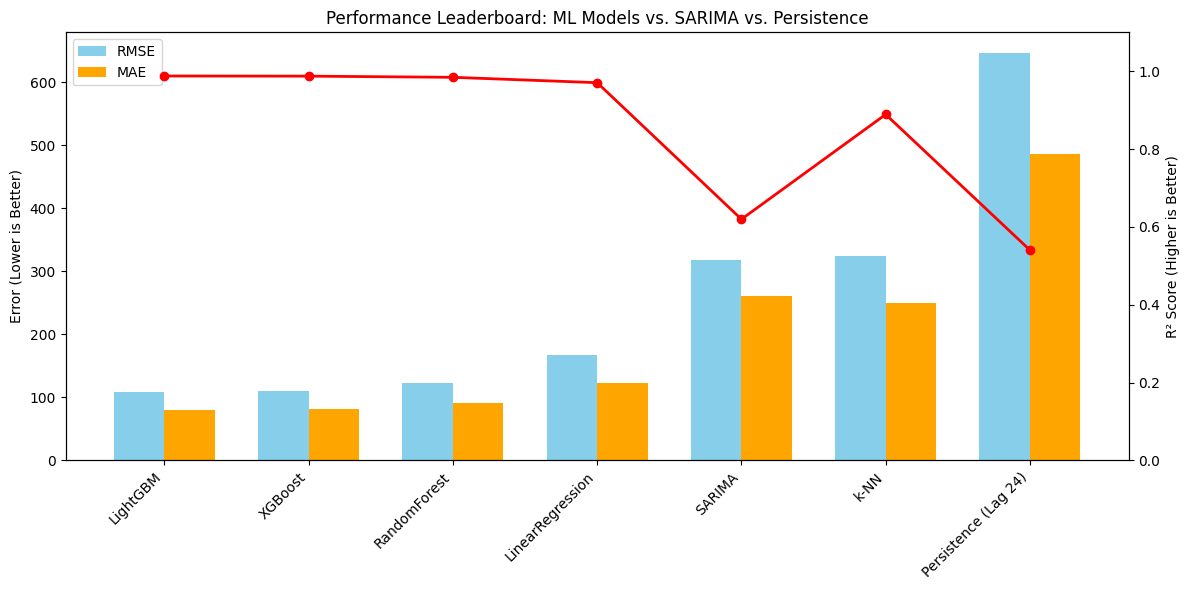

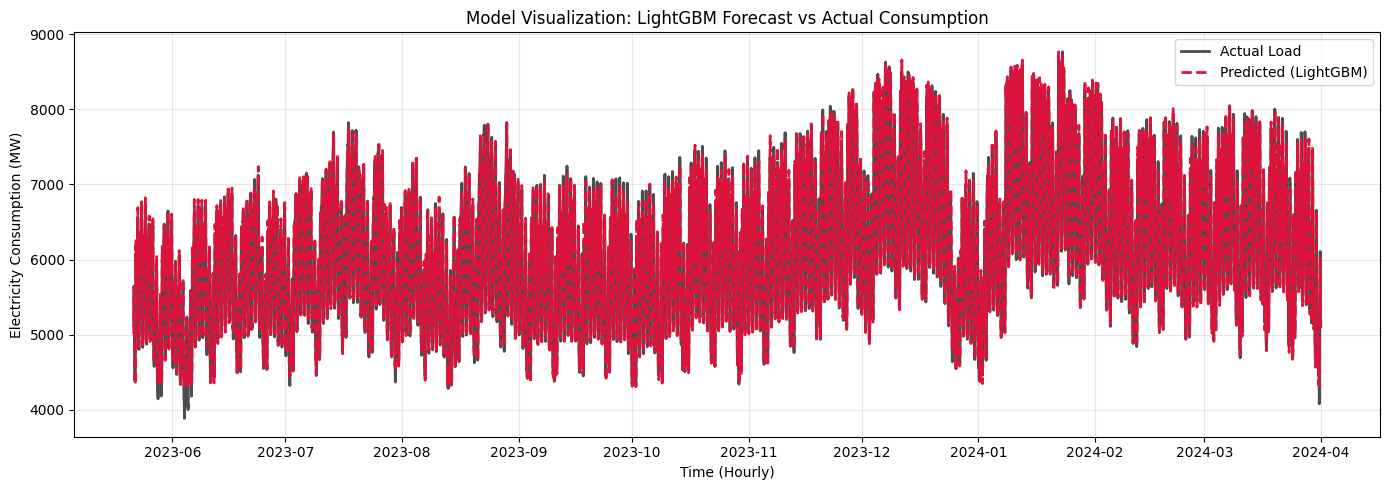

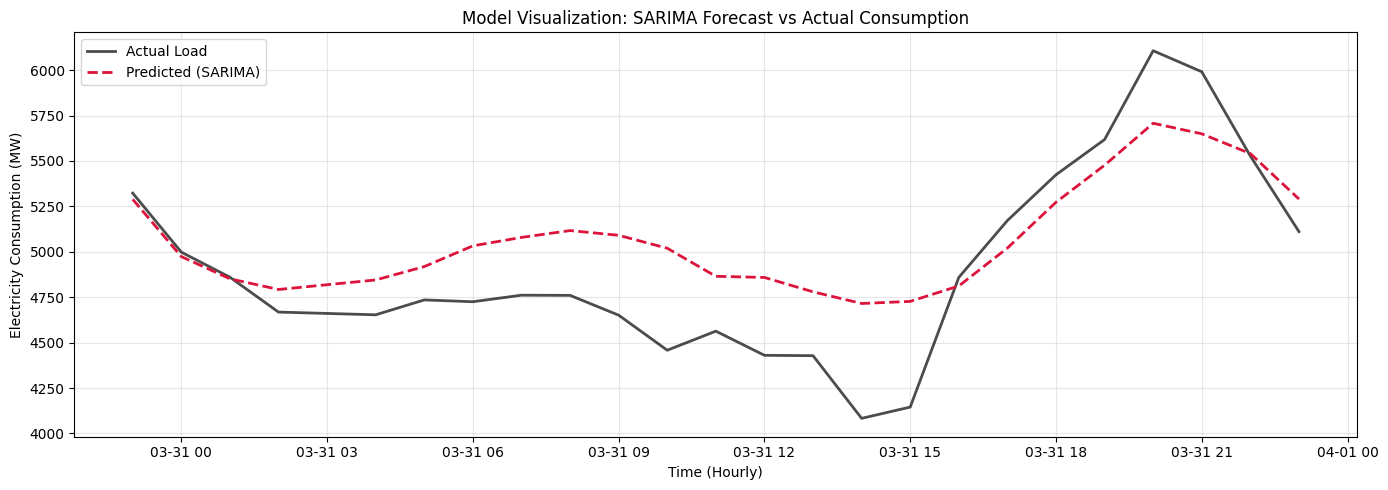

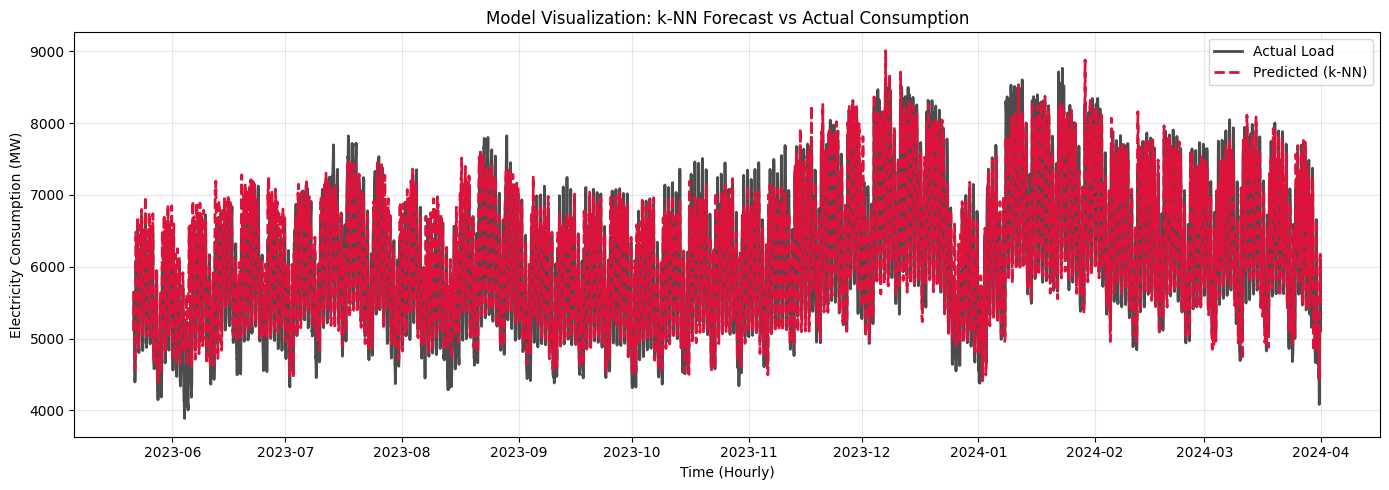

All final charts have been saved to: ../outputs


In [8]:
# ========================================================
# 🔹 FINAL COMPARISON CHART + PREDICTED VS ACTUAL
# ========================================================

import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure the output directory exists
OUTPUT_FOLDER = "../outputs"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 1️⃣ Comparison Chart (Includes Persistence as a benchmark)
x = np.arange(len(summary))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12,6))

# Bars for Error Metrics
ax1.bar(x - width/2, summary['RMSE'], width, label='RMSE', color='skyblue')
ax1.bar(x + width/2, summary['MAE'], width, label='MAE', color='orange')
ax1.set_xticks(x)
ax1.set_xticklabels(summary['Model'], rotation=45, ha='right')
ax1.set_ylabel('Error (Lower is Better)')

# Line for R²
ax2 = ax1.twinx()
ax2.plot(x, summary['R2'], marker='o', linewidth=2, label='R²', color='red')
ax2.set_ylabel('R² Score (Higher is Better)')
ax2.set_ylim(0, 1.1) 

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + labels2, labels1 + labels2, loc='upper left')

plt.title('Performance Leaderboard: ML Models vs. SARIMA vs. Persistence')
plt.tight_layout()

# SAVE the leaderboard
plt.savefig(f'{OUTPUT_FOLDER}/07_performance_leaderboard.png', dpi=300, bbox_inches='tight')
plt.show()

# 2️⃣ Predicted vs Actual (EXCLUDES Persistence)
# Filter summary to find real models, then sort by RMSE to find best/worst
real_models = summary[~summary['Model'].str.contains('Persistence')].sort_values('RMSE')
best_model_name = real_models.iloc[0]['Model']
worst_model_name = real_models.iloc[-1]['Model']

# Unique list of models to visualize
models_to_plot = list(set([best_model_name, worst_model_name, 'SARIMA']))

for model_name in models_to_plot:
    plt.figure(figsize=(14,5))

    if model_name == 'SARIMA':
        try:
            y_actual = test_s.values
            y_pred = sarima_pred.values
            index = test_s.index
        except NameError:
            print("SARIMA variables not found. Skipping plot.")
            continue
    else:
        # Pull from the dictionary created in the evaluation block
        y_actual_series, y_pred_values = last_fold_predictions[model_name]
        y_actual = y_actual_series.values
        y_pred = y_pred_values
        index = y_actual_series.index

    plt.plot(index, y_actual, label='Actual Load', color='black', alpha=0.7, linewidth=2)
    plt.plot(index, y_pred, label=f'Predicted ({model_name})', linestyle='--', color='crimson', linewidth=2)
    
    plt.title(f'Model Visualization: {model_name} Forecast vs Actual Consumption')
    plt.xlabel('Time (Hourly)')
    plt.ylabel('Electricity Consumption (MW)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # SAVE each forecast plot
    filename = f"{OUTPUT_FOLDER}/08_forecast_{model_name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

print(f"All final charts have been saved to: {OUTPUT_FOLDER}")